In [ ]:

import os
from collections import Counter

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pyarrow.parquet as pq
import seaborn as sns

from src.utils.data_utils import get_related_videos_with_keywords, keyword_searcher
from src.utils.general_utils import plot_wordcloud
from src.utils.evaluation_utils import diff_in_diff
from src.models.sentiment_analysis import SentimentAnalysisModel
from src.utils.sentiment_utils import *

# supress all warnings
import warnings
warnings.filterwarnings("ignore")

In [28]:
from src.utils.sentiment_utils import plot_sentiment_percentage_distribution_over_years

In [2]:
DATA_PATH = "/Users/iris/Documents/master@epfl/ma1/ADA_project/dataset"

In [31]:
# Load channel dataset
df_ch_f = pd.read_csv(
    os.path.join(DATA_PATH, "df_channels_en.tsv"), 
    compression="infer", 
    sep="\t"
)
df_ch_f["join_date"] = pd.to_datetime(df_ch_f["join_date"])

In [32]:
# Load timeseries dataset
df_ts_f = pd.read_csv(
    os.path.join(DATA_PATH, "df_timeseries_en.tsv.gz"), 
    compression="infer", 
    sep="\t"
)
df_ts_f["datetime"] = pd.to_datetime(df_ts_f["datetime"])

In [33]:
# Load video dataset without descriptions and tags
df_vd_f = pd.read_feather(
    os.path.join(DATA_PATH, "yt_metadata_helper.feather")
)

In [3]:
# Note: this dataset is created using script in src/scripts/sport_videos.py

# Load sports category videos dataset (with descriptions and tags)
pq_sports = pq.ParquetFile(os.path.join(DATA_PATH, "yt_metadata_en_sport.parquet"))
df_vd_sports = pq_sports.read().to_pandas()

# Change upload_date to datetime
df_vd_sports["upload_date"] = pd.to_datetime(df_vd_sports["upload_date"], format="%Y-%m-%d %H:%M:%S")

In [6]:
df_vd_sports.head()

,categories,channel_id,crawl_date,description,dislike_count,display_id,duration,like_count,tags,title,upload_date,view_count,title_sentiment
index,,,,,,,,,,,,,
1292,Sports,UCzWn_gTaXyH5Idyo8Raf7_A,2019-11-03 16:39:57.427254,Can I catch 100 lbs of catfish LIVE. Me and Ja...,35.0,JOeSxtcNdHQ,8620,1673.0,"catfishing,fishing,fishing challenge,catfish,c...",Catching 100 lbs of Catfish 🔴Live,2019-10-01,48737.0,neutral
1293,Sports,UCzWn_gTaXyH5Idyo8Raf7_A,2019-11-03 16:39:58.108323,,15.0,EPMLTw2zINw,355,1297.0,,big cat,2019-10-01,19999.0,neutral
1294,Sports,UCzWn_gTaXyH5Idyo8Raf7_A,2019-11-03 16:39:58.773085,Are you ready to enter the high fashion world ...,78.0,Y1_pK68iSYQ,603,3305.0,"Catfishing,how to catch catfish,fishing,classy...",Classy Catfishing - How to Catch Catfish the P...,2019-09-28,58518.0,neutral
1295,Sports,UCzWn_gTaXyH5Idyo8Raf7_A,2019-11-03 16:39:59.465346,Saltwater fishing out of Newquay Cornwall UK. ...,70.0,jF8TSo3ZfTc,1426,1889.0,"Fishing,Fishing uk,Angling,Sea angling,sea ang...",2 Day Saltwater Fishing Catch & Cook - UK Sea ...,2019-09-21,71998.0,neutral
1296,Sports,UCzWn_gTaXyH5Idyo8Raf7_A,2019-11-03 16:40:00.188768,My family spent 3 weeks touring England and fi...,73.0,Gp00dNaVouo,990,2699.0,"Fishing,catfish,wels catfish,how to catch catf...",How to Catch Wels Catfish - Fishing for Catfis...,2019-09-14,101924.0,neutral


# Part 2: Major sports events analysis

## Sentiment analysis

In [4]:
sentiment_model = SentimentAnalysisModel()

In [5]:
df_vd_sports['title_sentiment'] = df_vd_sports['title'].apply(
    lambda x: sentiment_model.get_sentiment_label(x)
)

We hypothesize that the sentiment of video titles can provide insights into public attitudes toward a given topic. By analyzing the sentiment of sports-related video titles uploaded over the years, we aim to understand how public attitudes toward sports have evolved over time.

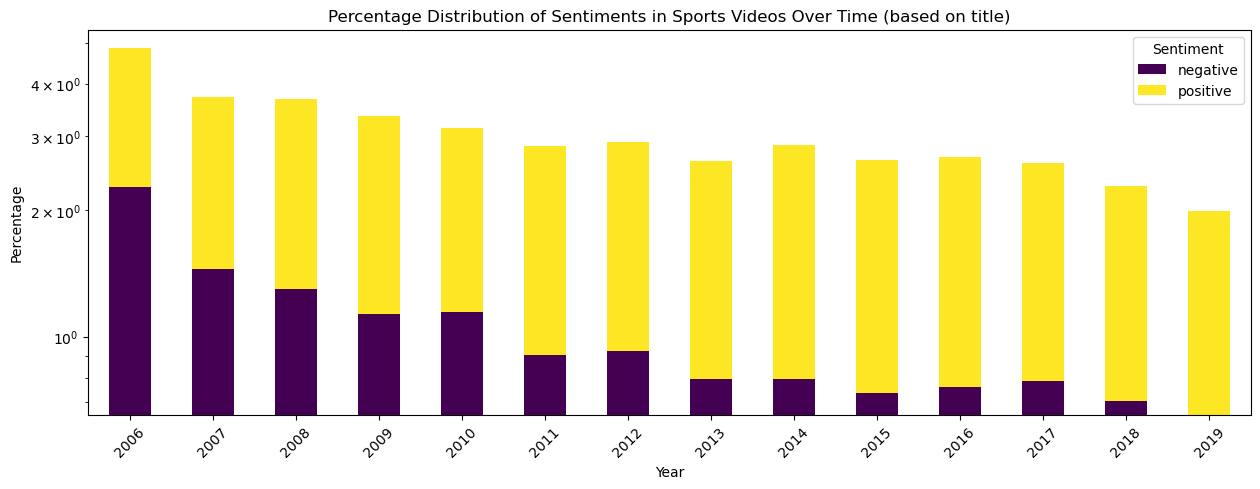

In [6]:
plot_sentiment_percentage_distribution_over_years(
    df_vd_sports, 
    sentiment_column="title_sentiment",
    title="Percentage Distribution of Sentiments in Sports Videos Over Time (based on title)"
)

The plot reveals that the majority of sports videos (over 95%) have a neutral sentiment. Additionally, negative videos make up less than 3% and show a declining trend over the years. This indicates that public attitudes—or at least those of sports content creators—toward sports have become less negative over time. To further validate this observation, we employ additional methods as below.

In [ ]:
mann_kendall_trend_test(df_vd_sports)

In [7]:
df_vd_sports["upload_data_y"] = df_vd_sports["upload_date"].dt.year

Mann-Kendall Test Result: Mann_Kendall_Test(trend='decreasing', h=True, p=1.953840894808323e-05, z=-4.2701014313206, Tau=-0.8681318681318682, s=-79.0, var_s=333.6666666666667, slope=-0.0006540175664625754, intercept=0.01276554698745264)


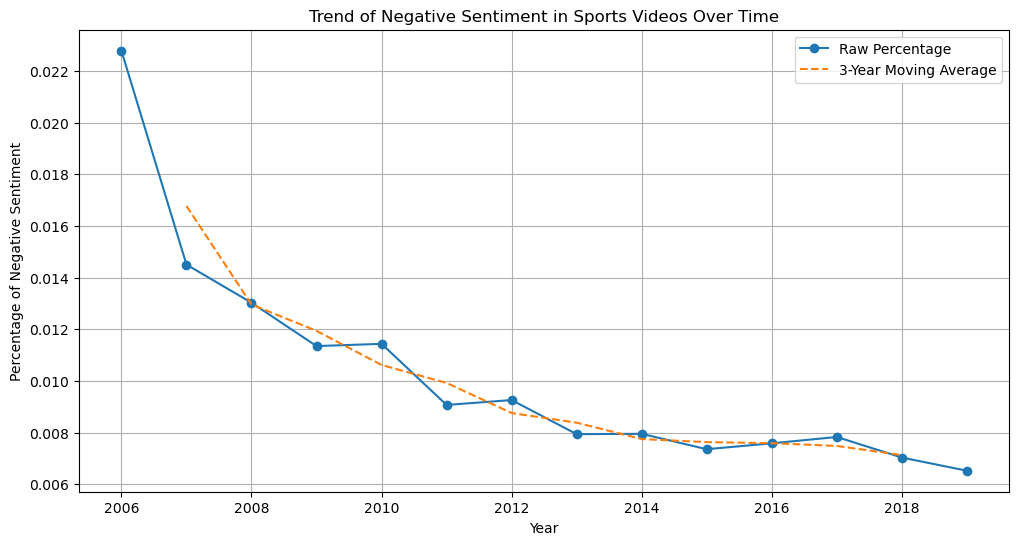

In [11]:
# Example Data: Replace this with your actual data
# Assuming df_vd_sports contains 'upload_date_y' and 'title_sentiment'
df_vd_sports['upload_date_y'] = df_vd_sports['upload_date'].dt.year

# Filter and calculate the yearly percentage of negative sentiment
negative_sentiment = df_vd_sports[df_vd_sports['title_sentiment'] == 'negative']
yearly_negative = (
    negative_sentiment.groupby('upload_date_y').size() /
    df_vd_sports.groupby('upload_date_y').size()
).reset_index(name='negative_percentage')

# Apply Moving Average for Smoothing
window_size = 3  # You can adjust the window size for smoothing
yearly_negative['smoothed_percentage'] = yearly_negative['negative_percentage'].rolling(window=window_size, center=True).mean()

# Perform Mann-Kendall Trend Test
mk_result = mk.original_test(yearly_negative['negative_percentage'].dropna())
print(f"Mann-Kendall Test Result: {mk_result}")

# Plotting the results
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(yearly_negative['upload_date_y'], yearly_negative['negative_percentage'], label='Raw Percentage', marker='o')
ax.plot(yearly_negative['upload_date_y'], yearly_negative['smoothed_percentage'], label=f'{window_size}-Year Moving Average', linestyle='--')
plt.title('Trend of Negative Sentiment in Sports Videos Over Time')
plt.xlabel('Year')
plt.ylabel('Percentage of Negative Sentiment')
plt.legend()
plt.grid()
plt.show()

We see that p-value < 0.05, indicating that there is indeed a significant decreasing trend in the negative sports content.

In [18]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from collections import Counter
from wordcloud import WordCloud
from gensim.corpora.dictionary import Dictionary
from gensim.models.ldamodel import LdaModel
from sklearn.feature_extraction.text import CountVectorizer

In [19]:
nltk.download('punkt')
nltk.download('stopwords')

negative_titles = df_vd_sports[df_vd_sports['title_sentiment'] == 'negative']['title']

# Preprocess titles: tokenize, remove stopwords, and lowercase
stop_words = set(stopwords.words('english'))
processed_titles = negative_titles.apply(lambda x: ' '.join(
    [word.lower() for word in word_tokenize(x) if word.isalpha() and word.lower() not in stop_words]
))

# Keyword analysis 
all_keywords = ' '.join(processed_titles)
keyword_counts = Counter(all_keywords.split())

top_keywords = keyword_counts.most_common(10)
print("Top keywords in negative titles:")
for keyword, count in top_keywords:
    print(f"{keyword}: {count}")

[nltk_data] Downloading package punkt to /Users/iris/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /Users/iris/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Top keywords in negative titles:
fight: 1800
fury: 1433
attack: 1237
vs: 992
worst: 963
insane: 946
crazy: 893
injury: 718
tyson: 689
bad: 677


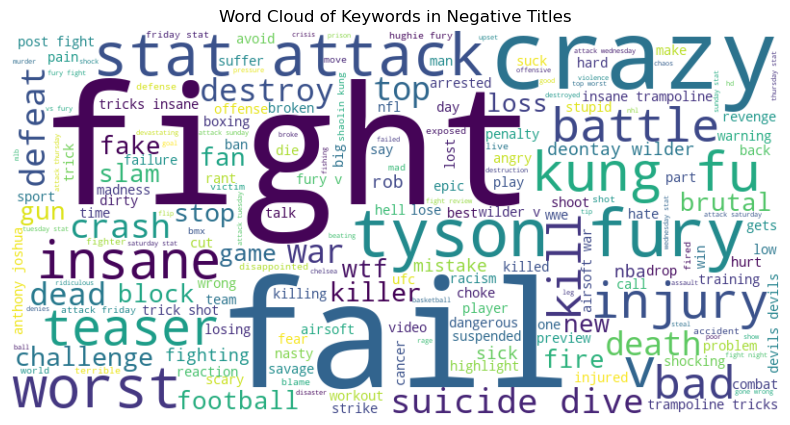

In [21]:
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_keywords)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Keywords in Negative Titles')
plt.show()

In [26]:
for title in negative_titles.sample(20):
    print(title)

DEONTAY WILDER " JOSHUA SKIPPED HARD FIGHTS TO AVOID HARD QUESTIONS"
Potato Gun
Rigondeaux banned from HBO
RAJESH KHANNA'S DEATH: FORMER BENGAL FOOTBALLERS ARE CRESTFALLEN
TIGER vs PHIL GOOD BAD AND THE UGLY
10 Wrestlers WWE Almost FIRED!
Apartment Fire
Team Insanity Bean Boozled CHALLENGE!
Fitz: Stop complaining about instant replay
Nascar Near Upsets
McDangle: Fighting's Death Clock
Drop toe hold from hell
CRAZY Lesbian Cheating Prаnks *GONЕ WRОNG*
PALUMBO'S PRISON BODYBUILDING CLASSIC? #askDave
MESSI DESTROYS DYBALA
Moose Ride or Die - Shake Junt
Ole Miss defeats Chattanooga 08/26/17
Dunks :: not so great
6 Wrestling Gimmicks That Died Horrible Deaths REACTION!!!
Hias Fu


In [27]:
df_vd_sports[df_vd_sports["title_sentiment"] == "negative"].sample(10)

,categories,channel_id,crawl_date,description,dislike_count,display_id,duration,like_count,tags,title,upload_date,view_count,title_sentiment,upload_data_y,upload_date_y
index,,,,,,,,,,,,,,,
164851,Sports,UCC4WLzWfGgfDUXX-3hvmIgQ,2019-11-18 09:29:04.948859,The song 👉Far Out - On My Own (feat. Karra)\n\...,64.0,rF3Go_fYMuo,263,2745.0,"MOST,LEGENDARY,Physiques,Top 10 physiques,2017...",THERE IS NO GIVING UP 🔥 Motivational Video,2018-10-02,195533.0,negative,2018,2018
158698,Sports,UC1CVzH-XVr3E-kTT6D8hhfg,2019-10-30 01:53:12.563704,Master Your Body ➤ http://www.fitnessfaqs.tv\n...,26.0,2_n1MvcsXEk,363,4689.0,"hollow body hold,hollow body position,hollow h...",The WORST Calisthenics ABS MISTAKES | Hollow Body,2017-11-30,87474.0,negative,2017,2017
738717,Sports,UCTY1M4RSWO60mH6GDiOTF9w,2019-11-12 17:27:38.108343,Our Website http://hooliganstv.eu/\n*bestelle ...,6.0,MGXok4eIbO4,30,23.0,"Околофутбола,aficionados,adeptos,confusao,torc...",Juve fans attacked by Sevilla hooligans 21.11....,2016-11-22,12490.0,negative,2016,2016
243063,Sports,UC5yB3mDwRyLNeRvfCSdKMeg,2019-11-08 04:21:50.694661,Reaction from the players after Real Madrid se...,0.0,fQOXO-JHc74,23,13.0,"UEFA Champions League,sport,sntv,Atletico Madr...",I can die happy- Ramos,2014-05-25,3984.0,negative,2014,2014
663386,Sports,UC5Y52fCWFDJh-4wkgSH4wDQ,2019-11-20 13:35:34.919205,Lt. Brian McGregor describes the incident lead...,1.0,JknOTaHaSoY,113,0.0,"3972069549001,Crime,cat2_Crime,cat1_News,Kenne...",Junior Galette Arrest,2015-01-05,277.0,negative,2015,2015
214968,Sports,UCX5qMbq8Y9h9TOdFhKUhkrw,2019-11-15 15:12:30.863375,MaxPreps Offense All-Americans,0.0,BS2djZzt45A,63,5.0,"maxpreps,high school,highlight",MaxPreps Offense All-Americans,2014-01-05,2503.0,negative,2014,2014
408413,Sports,UCFqDA12C4i24CMil_G_bwHw,2019-11-17 03:56:06.948612,,1.0,AlNUUHE0sug,22,3.0,,Jimmie Johnson caught CHEATING,2017-06-19,521.0,negative,2017,2017
915284,Sports,UCZ5C1HBPMEcCA1YGQmqj6Iw,2019-11-12 14:26:52.913493,USA Today Sports' Jeff Gluck looks ahead to th...,0.0,5ApL0jcmWBU,101,0.0,"5136066507001,smgvyoutube,SMGV,NASCAR,Jimmie J...",Bad Boy 300 Preview,2016-09-21,4.0,negative,2016,2016
125057,Sports,UCDm0d65Q9U1epfKM_ZiUJZA,2019-10-30 17:14:08.798632,We continue our sail to North Florida and fina...,14.0,TdOKSguZ0U4,929,2691.0,,Broke our autopilot :-( Caught some FISH :-),2018-12-13,34424.0,negative,2018,2018


TODO comment: I can die happy- Ramos, fight, ...
not really negative content?

In [28]:
df_vd_sports['description_sentiment'] = df_vd_sports['description'].apply(
    lambda x: sentiment_model.get_sentiment_label(x)
)

In [29]:
# TODO: should save df_vd_sports with sentiments to avoid runining again!

In [31]:
df_vd_sports.columns

Index(['categories', 'channel_id', 'crawl_date', 'description',
       'dislike_count', 'display_id', 'duration', 'like_count', 'tags',
       'title', 'upload_date', 'view_count', 'title_sentiment',
       'upload_data_y', 'upload_date_y', 'description_sentiment'],
      dtype='object')

In [32]:
# remove columns in df_vd_sports
df_vd_sports = df_vd_sports.drop(columns=["upload_data_y", "upload_date_y"])

In [34]:
df_vd_sports.to_parquet(os.path.join(DATA_PATH, "yt_metadata_en_sport_sentiments.parquet"), engine="pyarrow")

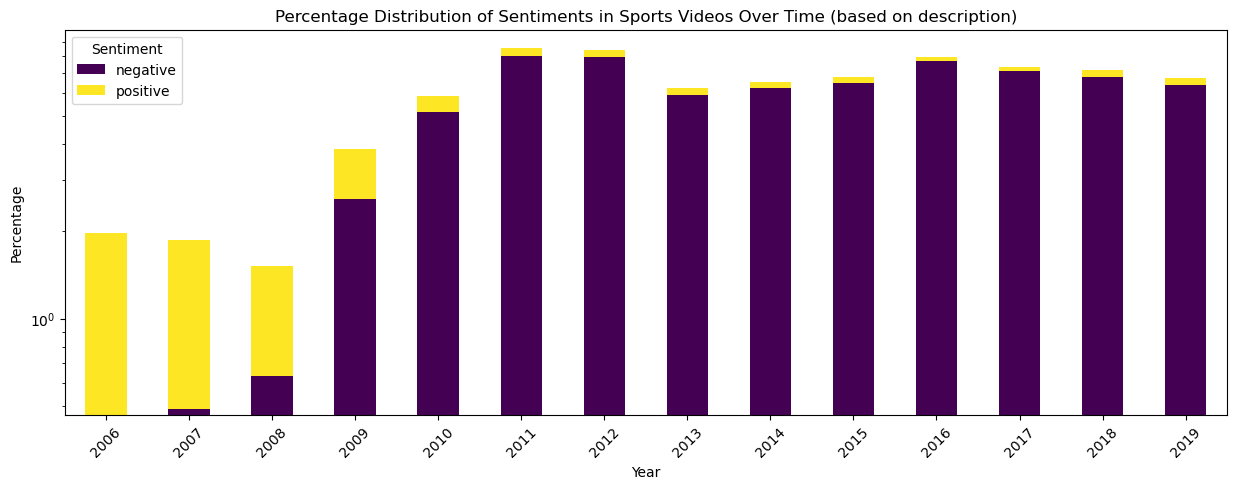

In [35]:
plot_sentiment_percentage_distribution_over_years(
    df_vd_sports, 
    sentiment_column="description_sentiment",
    title="Percentage Distribution of Sentiments in Sports Videos Over Time (based on description)"
)

In [38]:
df_vd_sports[df_vd_sports["description_sentiment"] == "negative"].sample(10)[["description", "title"]]

,description,title
index,,
789657,,وصفة رمضانية مع بروتين الكازيين - حلى قمر الدي...
214007,,Press Conference Petra Majdic Toblach
667743,,"NCAA Tournament Selection Reaction | Blair, Ho..."
380155,,2018 Bowman Baseball Jumbo HTA 1 Box Break for...
992253,,Interview with Ablaye Mbengue
552430,,Wheelz can't rap
84237,,Polish National Armwrestling Championships 201...
951644,,"Muscle Morning January 28, 2014"
335861,,RAMS ON TOUR | Lads Enjoying First Day


In [ ]:
# Topic modeling for sports videos based on description

# Preprocess descriptions: tokenize, remove stopwords, and lowercase
processed_descriptions = df_vd_sports['description'].apply(lambda x: ' '.join(
    [word.lower() for word in word_tokenize(x) if word.isalpha() and word.lower() not in stop_words]
))



In [22]:
# Topic modeling using LDA (Latent Dirichlet Allocation)
tokenized_titles = [title.split() for title in processed_titles]
dictionary = Dictionary(tokenized_titles)
corpus = [dictionary.doc2bow(title) for title in tokenized_titles]

# Train LDA model
lda_model = LdaModel(corpus=corpus, id2word=dictionary, num_topics=5, passes=10, random_state=42)

# Show top terms in each topic
print("Top terms in each topic:")
for idx, topic in lda_model.print_topics():
    print(f"Topic {idx}: {topic}")

Top terms in each topic:
Topic 0: 0.035*"attack" + 0.026*"suicide" + 0.026*"fight" + 0.022*"dive" + 0.017*"battle" + 0.016*"stat" + 0.012*"crash" + 0.010*"savage" + 0.010*"sick" + 0.010*"killer"
Topic 1: 0.016*"death" + 0.014*"fire" + 0.013*"wtf" + 0.010*"wrong" + 0.009*"gun" + 0.009*"stop" + 0.007*"killing" + 0.007*"friday" + 0.007*"wars" + 0.007*"crash"
Topic 2: 0.030*"fury" + 0.024*"fight" + 0.017*"teaser" + 0.017*"fu" + 0.016*"kung" + 0.016*"vs" + 0.015*"tyson" + 0.012*"fighting" + 0.011*"rob" + 0.009*"wilder"
Topic 3: 0.018*"bad" + 0.011*"pain" + 0.011*"hell" + 0.009*"kill" + 0.009*"new" + 0.008*"bomb" + 0.008*"offensive" + 0.007*"shoot" + 0.007*"die" + 0.007*"dirt"
Topic 4: 0.025*"worst" + 0.022*"insane" + 0.016*"crazy" + 0.014*"injury" + 0.014*"fail" + 0.012*"slam" + 0.012*"tricks" + 0.012*"football" + 0.012*"top" + 0.011*"fails"


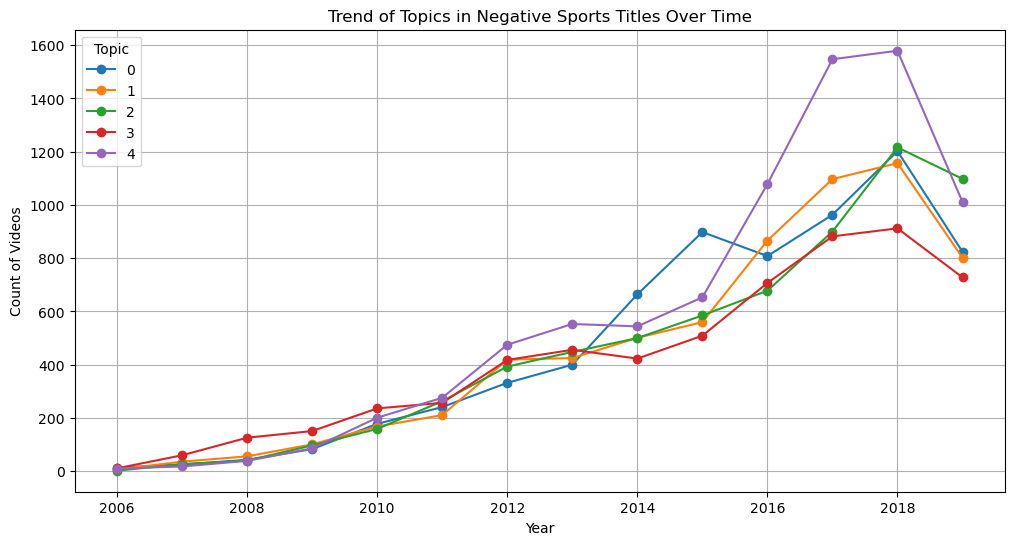

In [23]:
# Analyze Topic Trends Over Time
df_negative_titles = df_vd_sports[df_vd_sports['title_sentiment'] == 'negative'][['upload_date_y', 'title']]
df_negative_titles['processed'] = tokenized_titles
df_negative_titles['topic'] = [
    max(lda_model[dictionary.doc2bow(text)], key=lambda x: x[1])[0] for text in df_negative_titles['processed']
]

# Count topics per year
topic_counts = df_negative_titles.groupby(['upload_date_y', 'topic']).size().unstack(fill_value=0)

# Plot topic trends
fig, ax = plt.subplots(figsize=(12, 6))
topic_counts.plot(kind='line', ax=ax, marker='o')
plt.title('Trend of Topics in Negative Sports Titles Over Time')
plt.xlabel('Year')
plt.ylabel('Count of Videos')
plt.legend(title='Topic')
plt.grid()
plt.show()

In [31]:
# Group the data by year and sentiment and count the occurrences
df = df_vd_sports.copy()
df['upload_date_y'] = df['upload_date'].dt.year
sentiment_counts = df.groupby(['upload_date_y', 'title_sentiment']).size().reset_index(name='count')

# Calculate the total counts per year
total_counts_per_year = sentiment_counts.groupby('upload_date_y')['count'].transform('sum')

# Calculate the percentage of each sentiment
sentiment_counts['percentage'] = sentiment_counts['count'] / total_counts_per_year * 100


In [11]:
sentiment_counts

,upload_date_y,title_sentiment,count,percentage
0,2005,neutral,3,100.000000
1,2006,negative,44,2.278612
2,2006,neutral,1837,95.132056
3,2006,positive,50,2.589332
4,2007,negative,166,1.450669
5,2007,neutral,11016,96.268461
6,2007,positive,261,2.280870
7,2008,negative,304,1.303155
8,2008,neutral,22467,96.309156
9,2008,positive,557,2.387689


In [ ]:
olympics_keywords = [
    'olympic', 'olympics', 'olympiad', 'beijing 2008', 'london 2012',
    'rio 2016', 'pyeongchang 2018', 'sochi 2014', 'tokyo 2020', 'olympic games',
    'winter olympics', 'summer olympics'
]

df_olympics = keyword_searcher(df_vd_sports, olympics_keywords, columns=["tags"])

In [ ]:
world_cup_keywords = [
   'world cup', 'worldcup', '2018 russia', '2014 brazil', '2010 south africa',
]

df_world_cup = get_related_videos_with_keywords(df_vd_sports, world_cup_keywords)

In [ ]:
nba_keywords = [
    'nba', 'national basketball association'
]

df_nba = get_related_videos_with_keywords(df_vd_sports, nba_keywords)